In [76]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct, when

In [77]:
spark = SparkSession.builder \
    .appName("AnaliseEmpregoMatriculas") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

In [78]:
caminho_parquet_base = 'data/matriculas.parquet'
caminho_parquet_secundario = 'data/microdados_2007.parquet'

In [79]:
df_matriculas = spark.read.parquet(caminho_parquet_base)
df_emprego = spark.read.parquet(caminho_parquet_secundario)

In [80]:
print("Colunas emprego:", df_emprego.columns)
print("Colunas matriculas:", df_matriculas.columns)

Colunas emprego: ['ano', 'mes', 'sigla_uf', 'id_municipio', 'id_municipio_6', 'admitidos_desligados', 'tipo_estabelecimento', 'tipo_movimentacao_desagregado', 'faixa_emprego_inicio_janeiro', 'tempo_emprego', 'quantidade_horas_contratadas', 'salario_mensal', 'saldo_movimentacao', 'indicador_aprendiz', 'indicador_trabalho_intermitente', 'indicador_trabalho_parcial', 'indicador_portador_deficiencia', 'tipo_deficiencia', 'grau_instrucao', 'idade', 'sexo', 'raca_cor']
Colunas matriculas: ['ano', 'sigla_uf', 'id_municipio', 'rede', 'id_aluno', 'id_matricula', 'idade', 'sexo', 'raca_cor', 'necessidade_especial', 'baixa_visao', 'cegueira', 'deficiencia_auditiva', 'deficiencia_fisica', 'deficiencia_intelectual', 'surdez', 'surdocegueira', 'deficiencia_multipla', 'superdotacao', 'etapa_ensino', 'especial_exclusiva', 'regular', 'eja', 'profissionalizante']


In [81]:
df_emprego.show()

+----+---+--------+------------+--------------+--------------------+--------------------+-----------------------------+----------------------------+-------------+----------------------------+--------------+------------------+------------------+-------------------------------+--------------------------+------------------------------+----------------+--------------+-----+----+--------+
| ano|mes|sigla_uf|id_municipio|id_municipio_6|admitidos_desligados|tipo_estabelecimento|tipo_movimentacao_desagregado|faixa_emprego_inicio_janeiro|tempo_emprego|quantidade_horas_contratadas|salario_mensal|saldo_movimentacao|indicador_aprendiz|indicador_trabalho_intermitente|indicador_trabalho_parcial|indicador_portador_deficiencia|tipo_deficiencia|grau_instrucao|idade|sexo|raca_cor|
+----+---+--------+------------+--------------+--------------------+--------------------+-----------------------------+----------------------------+-------------+----------------------------+--------------+------------------+-

In [82]:
df_matriculas.show()

+----+--------+------------+----+--------------------+------------+-----+----+--------+--------------------+-----------+--------+--------------------+------------------+-----------------------+------+-------------+--------------------+------------+------------+------------------+-------+----+------------------+
| ano|sigla_uf|id_municipio|rede|            id_aluno|id_matricula|idade|sexo|raca_cor|necessidade_especial|baixa_visao|cegueira|deficiencia_auditiva|deficiencia_fisica|deficiencia_intelectual|surdez|surdocegueira|deficiencia_multipla|superdotacao|etapa_ensino|especial_exclusiva|regular| eja|profissionalizante|
+----+--------+------------+----+--------------------+------------+-----+----+--------+--------------------+-----------+--------+--------------------+------------------+-----------------------+------+-------------+--------------------+------------+------------+------------------+-------+----+------------------+
|2007|      MS|     5002704|   2|4168D7697C4974BED...|   1123

In [83]:
# 4. Métricas gerais de emprego
df_emprego_agg = df_emprego.groupBy('ano', 'sigla_uf').agg(
    count(when(col('admitidos_desligados') == 1, True)).alias('total_empregados'),
    count(when(col('admitidos_desligados') == 2, True)).alias('total_desempregados')
)

In [84]:
# 5. Métricas de matrícula
df_matriculas_agg = df_matriculas.groupBy('ano', 'sigla_uf').agg(
    countDistinct('id_matricula').alias('total_matriculas')
)

In [85]:
# 6. Métricas por raça
df_raca_agg = df_emprego.groupBy('ano', 'sigla_uf', 'raca_cor').agg(
    count(when(col('admitidos_desligados') == 1, True)).alias('empregados_raca'),
    count(when(col('admitidos_desligados') == 2, True)).alias('desempregados_raca')
)

In [86]:
# 7. Métricas por deficiência
df_deficiencia_agg = df_emprego.groupBy('ano', 'sigla_uf', 'indicador_portador_deficiencia').agg(
    count(when(col('admitidos_desligados') == 1, True)).alias('empregados_deficiencia'),
    count(when(col('admitidos_desligados') == 2, True)).alias('desempregados_deficiencia')
)

In [87]:
# 8. Juntar as métricas principais
df_analise = df_emprego_agg.join(
    df_matriculas_agg,
    on=['ano', 'sigla_uf'],
    how='inner'
)

In [88]:
# 9. Criar as métricas calculadas
df_analise = df_analise.withColumn(
    'desligados_por_1000_matriculas',
    (col('total_desempregados') / col('total_matriculas')) * 1000
).withColumn(
    'taxa_desemprego',
    (col('total_desempregados') / (col('total_empregados') + col('total_desempregados'))) * 100
).withColumn(
    'empregados_por_desempregado',
    (col('total_empregados') / col('total_desempregados'))
)

In [89]:
# 10. Exportar CSVs separados para análises detalhadas
df_analise.toPandas().to_csv('analise_geral.csv', index=False)
df_raca_agg.toPandas().to_csv('analise_por_raca.csv', index=False)
df_deficiencia_agg.toPandas().to_csv('analise_por_deficiencia.csv', index=False)

In [90]:
# Dicionário de UFs para regiões
uf_para_regiao = {
    'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste',
    'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Criar UDF para mapear sigla_uf para região
def uf_para_regiao_func(uf):
    return uf_para_regiao.get(uf, 'Desconhecida')

uf_para_regiao_udf = udf(uf_para_regiao_func, StringType())

# Aplicar
df_analise = df_analise.withColumn('regiao', uf_para_regiao_udf(col('sigla_uf')))


In [91]:
df_analise.write.mode('overwrite').csv('data/analise_final', header=True)

In [92]:
df_analise.toPandas().to_csv('analise_final.csv', index=False)


In [93]:
import matplotlib.pyplot as plt


In [94]:
df_plot = df_analise.toPandas()

✅ 1. Gráfico: Taxa de desemprego por estado

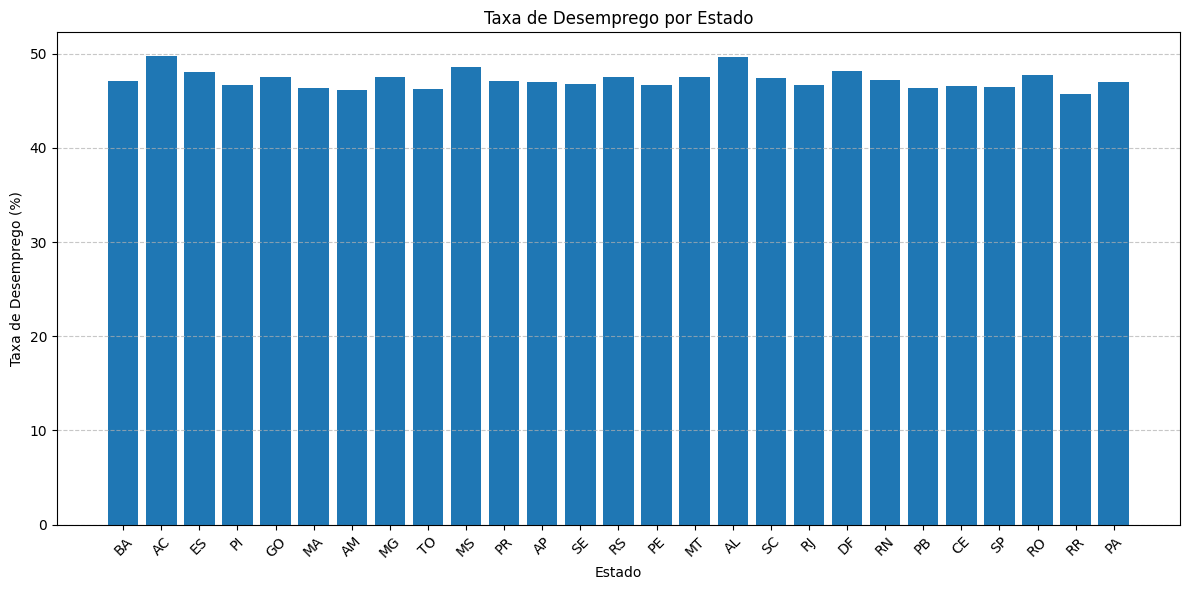

In [95]:
plt.figure(figsize=(12, 6))
plt.bar(df_plot['sigla_uf'], df_plot['taxa_desemprego'])
plt.title('Taxa de Desemprego por Estado')
plt.xlabel('Estado')
plt.ylabel('Taxa de Desemprego (%)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('grafico_taxa_desemprego.png')
plt.show()

 2. Gráfico: Relação empregados por desempregado por estado

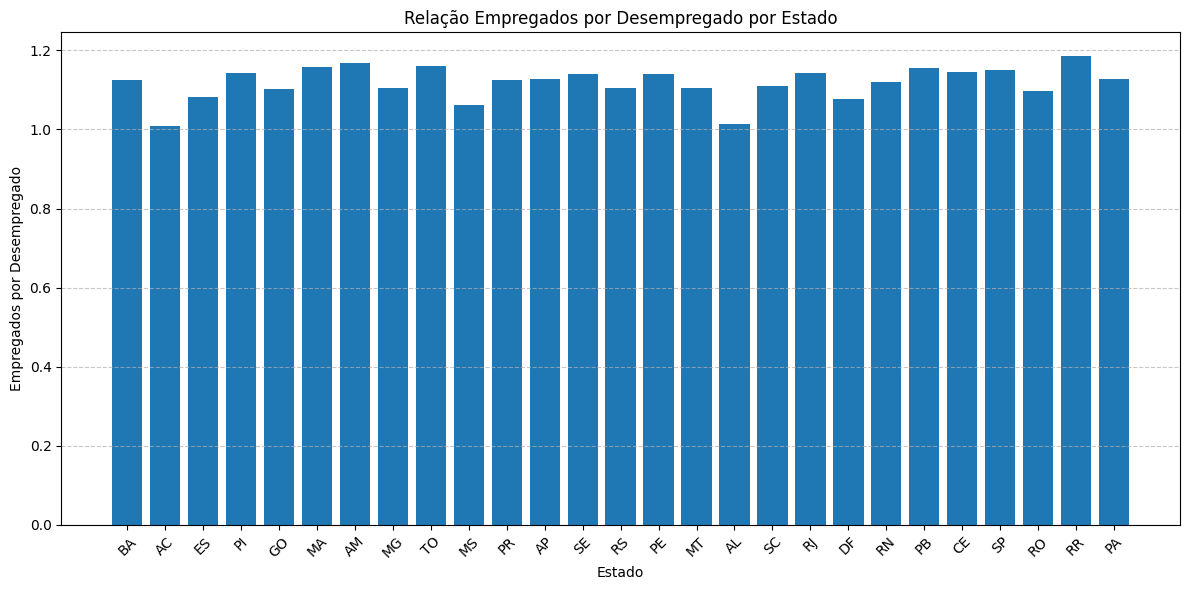

In [96]:
plt.figure(figsize=(12, 6))
plt.bar(df_plot['sigla_uf'], df_plot['empregados_por_desempregado'])
plt.title('Relação Empregados por Desempregado por Estado')
plt.xlabel('Estado')
plt.ylabel('Empregados por Desempregado')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('grafico_empregados_por_desempregado.png')
plt.show()


✅3. Gráfico: Desligados por 1000 matrículas por região

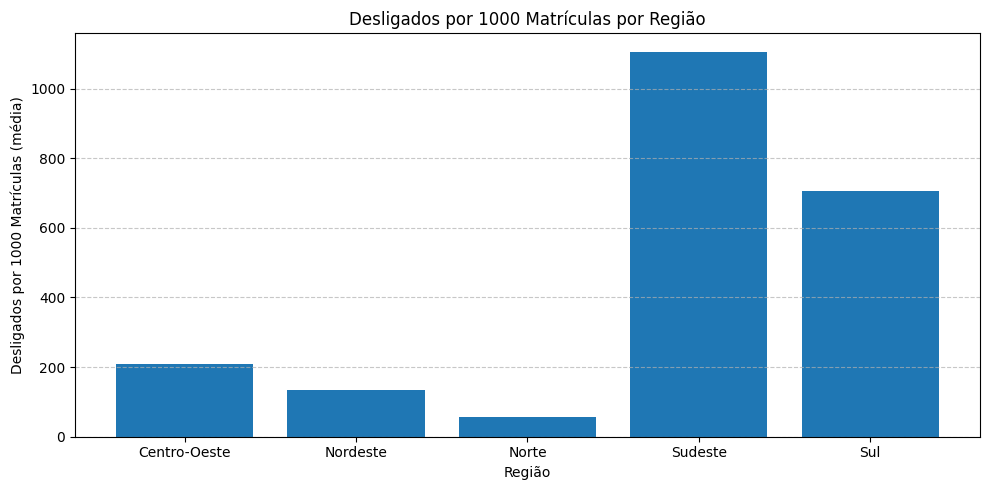

In [97]:
df_regiao = df_plot.groupby('regiao')[['desligados_por_1000_matriculas']].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(df_regiao['regiao'], df_regiao['desligados_por_1000_matriculas'])
plt.title('Desligados por 1000 Matrículas por Região')
plt.xlabel('Região')
plt.ylabel('Desligados por 1000 Matrículas (média)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('grafico_desligados_por_regiao.png')
plt.show()


✅ 4. Gráfico: Empregados vs. Desempregados por estado (comparativo)

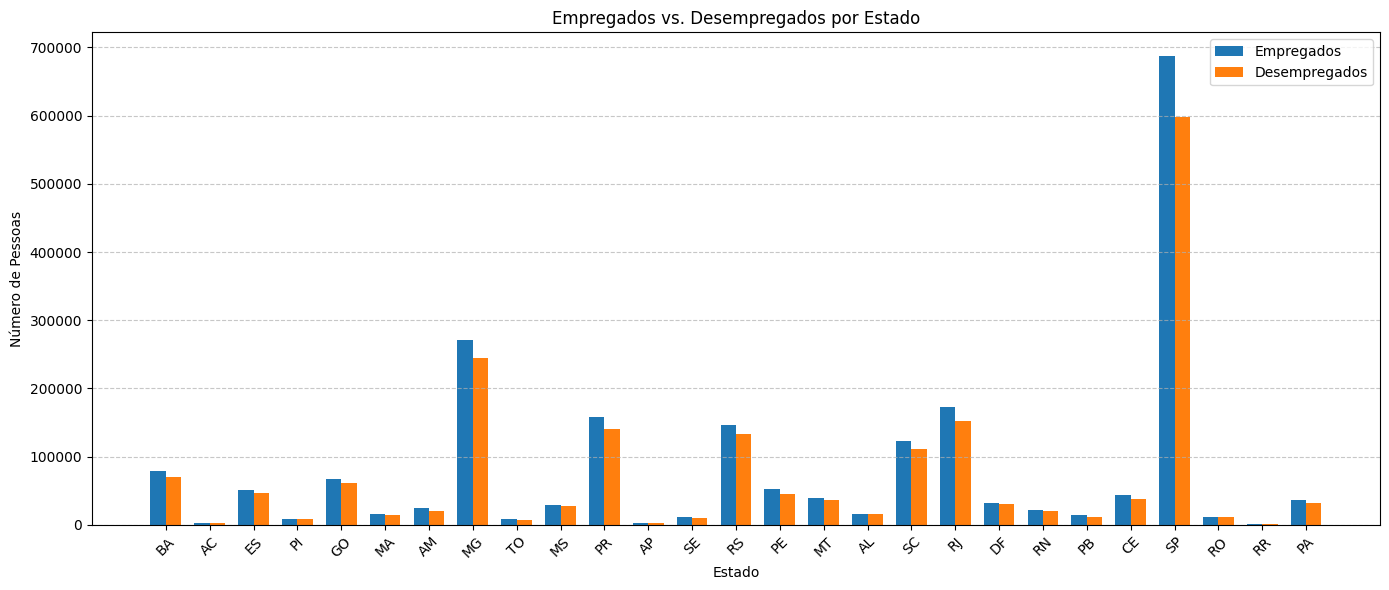

In [98]:
import numpy as np

x = np.arange(len(df_plot['sigla_uf']))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, df_plot['total_empregados'], width, label='Empregados')
plt.bar(x + width/2, df_plot['total_desempregados'], width, label='Desempregados')
plt.title('Empregados vs. Desempregados por Estado')
plt.xlabel('Estado')
plt.ylabel('Número de Pessoas')
plt.xticks(x, df_plot['sigla_uf'], rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('grafico_empregados_vs_desempregados.png')
plt.show()
